In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import math
import query  # Ensure your query.py is accessible

In [18]:
stocks = [
    "TSLA",  # Tesla
    "MSFT",  # Microsoft
    # "PG",    # Procter & Gamble
    # "META",  # Meta Platforms (formerly Facebook)
    # "AMZN",  # Amazon
    # "GOOG",  # Alphabet (Google)
    # "AMD",   # Advanced Micro Devices
    # "AAPL",  # Apple
    # "NFLX",  # Netflix
    # "TSM",   # Taiwan Semiconductor Manufacturing
    # "KO",    # Coca-Cola
    # "F",     # Ford Motor
    # "COST",  # Costco Wholesale
    # "DIS",   # Disney
    # "VZ",    # Verizon Communications
    # "CRM",   # Salesforce
    # "INTC",  # Intel
    # "BA",    # Boeing
    # "BX",    # Blackstone
    # "NOC",   # Northrop Grumman
    # "PYPL",  # PayPal
    # "ENPH",  # Enphase Energy
    # "NIO",   # NIO Inc.
    # "ZS",    # Zscaler
    # "XPEV"   # XPeng
]


In [13]:
# Function to prepare data for a single company with moving average feature
def prepare_data_for_company(stock_symbol, window_size=5):
    df_price = query.avg_stock_price(stock_symbol)
    df_sentiment = query.avg_daily_sentiment(stock_symbol)
    df_merged = pd.merge(df_price, df_sentiment, on=['date', 'company_name'], how='inner')

    # Filter for a specific company
    df_filtered = df_merged[df_merged['stock_symbol'] == stock_symbol]

    df_filtered['date'] = pd.to_datetime(df_filtered['date'])
    df_filtered.set_index('date', inplace=True)

    # Calculate moving average
    df_filtered['moving_average'] = df_filtered['average_stock_price'].rolling(window=window_size, min_periods=1).mean()

    # Fill NaN values in 'moving_average' column with forward fill
    df_filtered['moving_average'].fillna(method='ffill', inplace=True)

    # Fill NaN values in other columns with forward fill
    df_filtered.fillna(method='ffill', inplace=True)

    return df_filtered[['sentiment_value', 'moving_average']], df_filtered['average_stock_price']


In [14]:
# Function to create dataset for LSTM
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        v = X[i:(i + time_steps)]
        Xs.append(v)
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

In [15]:
# Function to create, compile, and train LSTM model
def train_lstm_model(X_train, y_train, X_test, y_test):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=100, batch_size=32, verbose=1)
    return model

In [16]:
# Function to evaluate the model
def evaluate_model(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

Training model for TSLA
Index(['date', 'company_id', 'company_name', 'ticker_symbol',
       'sentiment_value'],
      dtype='object')
Epoch 1/100
2/2 [==============================] - 2s 7ms/step - loss: 0.3019
Epoch 2/100
2/2 [==============================] - 0s 6ms/step - loss: 0.2114
Epoch 3/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1425
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0836
Epoch 5/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0427
Epoch 6/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0231
Epoch 7/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0262
Epoch 8/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0454
Epoch 9/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0509
Epoch 10/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0321
Epoch 11/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0256
Epoch

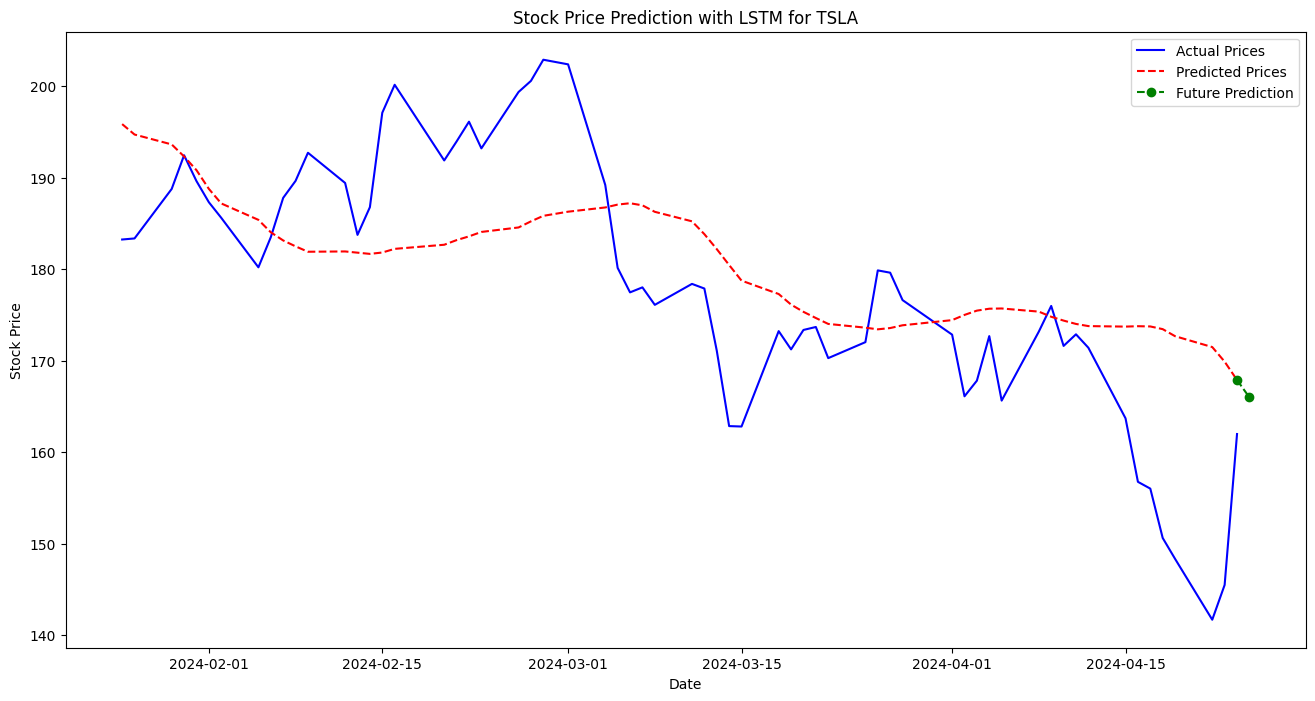

Training model for MSFT
Index(['date', 'company_id', 'company_name', 'ticker_symbol',
       'sentiment_value'],
      dtype='object')
Epoch 1/100
2/2 [==============================] - 2s 6ms/step - loss: 0.3562
Epoch 2/100
2/2 [==============================] - 0s 5ms/step - loss: 0.2697
Epoch 3/100
2/2 [==============================] - 0s 7ms/step - loss: 0.1838
Epoch 4/100
2/2 [==============================] - 0s 6ms/step - loss: 0.1186
Epoch 5/100
2/2 [==============================] - 0s 5ms/step - loss: 0.0584
Epoch 6/100
2/2 [==============================] - 0s 7ms/step - loss: 0.0314
Epoch 7/100
2/2 [==============================] - 0s 7ms/step - loss: 0.0475
Epoch 8/100
2/2 [==============================] - 0s 7ms/step - loss: 0.0620
Epoch 9/100
2/2 [==============================] - 0s 7ms/step - loss: 0.0626
Epoch 10/100
2/2 [==============================] - 0s 6ms/step - loss: 0.0410
Epoch 11/100
2/2 [==============================] - 0s 7ms/step - loss: 0.0289
Epoch

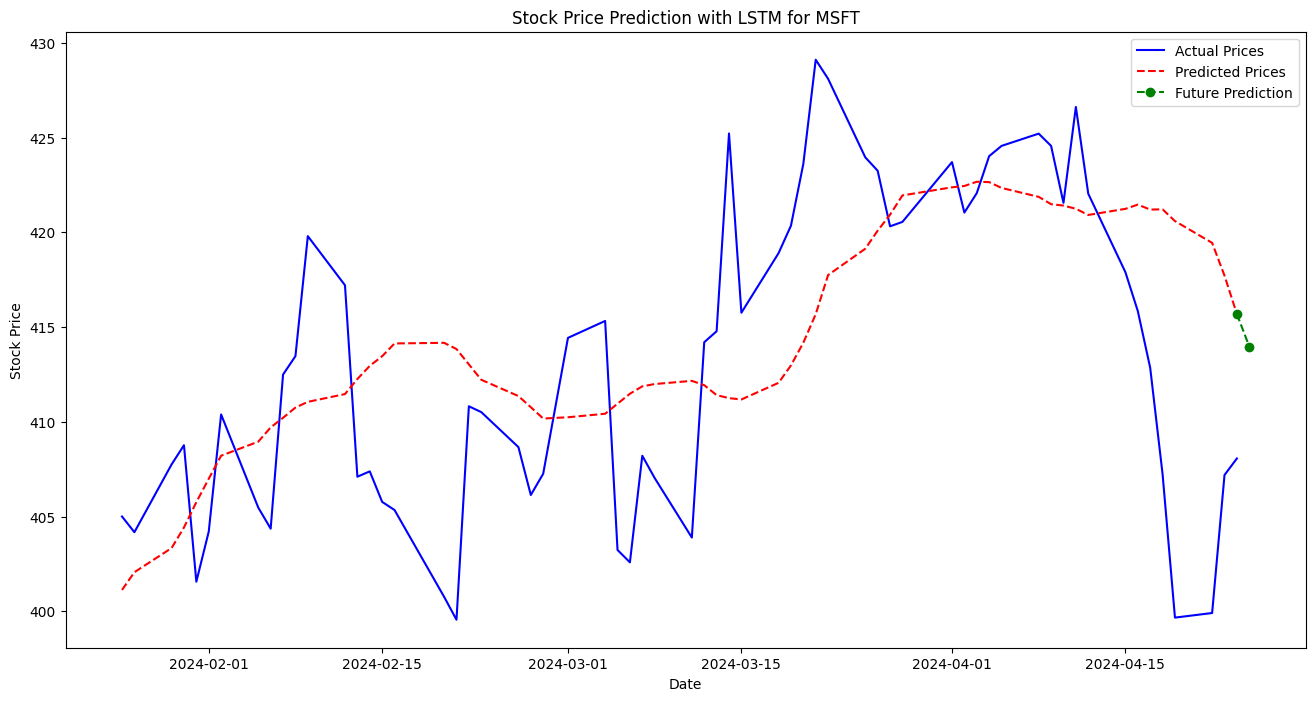

In [46]:
results = []

for company in stocks:
    print(f"Training model for {company}")
    features, target = prepare_data_for_company(company)
    scaler_features = MinMaxScaler(feature_range=(0, 1))
    scaler_target = MinMaxScaler(feature_range=(0, 1))
    scaled_features = scaler_features.fit_transform(features)
    scaled_target = scaler_target.fit_transform(target.values.reshape(-1, 1))
    time_steps = 7
    X, y = create_dataset(scaled_features, scaled_target, time_steps)
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    model = train_lstm_model(X_train, y_train, X_test, y_test)
    y_pred_scaled = model.predict(X)
    y_pred = scaler_target.inverse_transform(y_pred_scaled)
    dates = features.index[time_steps:]
    
    # Store in results
    for date, actual, predicted in zip(dates, scaler_target.inverse_transform(y), y_pred):
        results.append((date, actual[0], predicted[0], company))

    # Evaluate the model on test data
    y_test_pred_scaled = model.predict(X_test)
    y_test_pred = scaler_target.inverse_transform(y_test_pred_scaled.reshape(-1, 1))
    mae, mse, rmse, r2 = evaluate_model(scaler_target.inverse_transform(y_test), y_test_pred)

    print(f"Evaluation results for {company}:")
    print(f"Mean Absolute Error (MAE): {mae}")
    print(f"Mean Squared Error (MSE): {mse}")
    print(f"Root Mean Squared Error (RMSE): {rmse}")
    print(f"R-squared (R2) Score: {r2}")


    # Forecasting future prices
    last_sequence = scaled_features[-time_steps:]
    last_sequence = np.expand_dims(last_sequence, axis=0)
    future_scaled = model.predict(last_sequence)
    future = scaler_target.inverse_transform(future_scaled)
    future_dates = pd.date_range(start=dates[-1], periods=2, freq='B')
    results.append((future_dates[1], None, future[0][0], company))
    
    # Plotting
    plt.figure(figsize=(16, 8))
    plt.plot(dates, scaler_target.inverse_transform(y), label="Actual Prices", color='blue')
    plt.plot(dates, y_pred, label="Predicted Prices", color='red', linestyle='--')
    plt.plot(future_dates, [y_pred[-1][0], future[0][0]], label="Future Prediction", color='green', linestyle='--', marker='o')

    plt.title(f"Stock Price Prediction with LSTM for {company}")
    plt.xlabel("Date")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()

In [47]:
results

[(Timestamp('2024-01-25 00:00:00'), 183.25428571428571, 195.86444, 'TSLA'),
 (Timestamp('2024-01-26 00:00:00'), 183.37142857142857, 194.72575, 'TSLA'),
 (Timestamp('2024-01-29 00:00:00'), 188.77857142857147, 193.6433, 'TSLA'),
 (Timestamp('2024-01-30 00:00:00'), 192.46, 192.3272, 'TSLA'),
 (Timestamp('2024-01-31 00:00:00'), 189.64, 190.83395, 'TSLA'),
 (Timestamp('2024-02-01 00:00:00'), 187.32857142857142, 188.78609, 'TSLA'),
 (Timestamp('2024-02-02 00:00:00'), 185.62571428571428, 187.19427, 'TSLA'),
 (Timestamp('2024-02-05 00:00:00'), 180.21714285714285, 185.4023, 'TSLA'),
 (Timestamp('2024-02-06 00:00:00'), 183.50571428571425, 184.04347, 'TSLA'),
 (Timestamp('2024-02-07 00:00:00'), 187.80428571428573, 183.15166, 'TSLA'),
 (Timestamp('2024-02-08 00:00:00'), 189.66, 182.50659, 'TSLA'),
 (Timestamp('2024-02-09 00:00:00'), 192.73285714285714, 181.91763, 'TSLA'),
 (Timestamp('2024-02-12 00:00:00'), 189.43285714285713, 181.95042, 'TSLA'),
 (Timestamp('2024-02-13 00:00:00'), 183.76, 181.816